<a href="https://colab.research.google.com/github/panda-yoo/ML_practice_code/blob/master/2d_heat_equation_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

$\alpha^2$($\frac{\partial{^2u}}{\partial{x^2}}$+$\frac{\partial{^2u}}{\partial{y^2}}$) = $\frac{\partial{u}}{\partial{t}}$

In [ ]:
pi = th.pi

In [ ]:
class PINN(nn.Module):
    def __init__(self) :
        super().__init__()

        self.net = nn.Sequential(nn.Linear(3,64),
                                 nn.Tanh(),
                                 nn.Linear(64,64),
                                 nn.Tanh(),
                                 nn.Linear(64,1),
          )
    def forward(self,x):
        return self.net(x)




In [ ]:
# def initial_condition(x,y):
#     return th.sin(pi*x) * th.sin(pi*y)

def initial_condition(x,y):
    ten = th.zeros_like(x)
    ten[x.shape[0]//2] = 10
    return ten

def boundary_condition(x,y,t,custom_values):

    return th.full_like(input = x ,fill_value=custom_values)

def generate_training_points(num_points):
    x = th.rand(size = (num_points, 1 ),requires_grad=True)
    y = th.rand(size = (num_points, 1 ),requires_grad=True)
    t = th.rand(size = (num_points, 1 ),requires_grad=True)
    return x,y,t

def generate_boundary_points(num_points):
    x_boundary = th.tensor([0.0 , 1.0]).repeat(num_points//2)
    y_boundary = th.rand(num_points)

    if th.rand(1) > 0.5 :
        x_boundary,y_boundary = y_boundary ,x_boundary

    return x_boundary.view(-1,1) , y_boundary.view(-1,1)

def generate_boundary_training_data(num_points):

    x_boundary,y_boundary = generate_boundary_points(num_points=num_points)
    t = th.rand(size=(num_points,1) , requires_grad=True)

    return x_boundary,y_boundary,t


def pde(model,x,y,t):
    input_data = th.cat([x,y,t] , dim=1)
    u = model(input_data)

    u_x = th.autograd.grad(u,x,grad_outputs=th.ones_like(u),create_graph=True,retain_graph=True)[0]
    u_xx = th.autograd.grad(u_x,x,grad_outputs=th.ones_like(u),create_graph=True,retain_graph=True)[0]


    u_y = th.autograd.grad(u,y,grad_outputs=th.ones_like(u),create_graph=True,retain_graph=True)[0]
    u_yy = th.autograd.grad(u_y,x,grad_outputs=th.ones_like(u),create_graph=True,retain_graph=True)[0]

    u_t = th.autograd.grad(u,t,grad_outputs=th.ones_like(u),create_graph=True,retain_graph=True)[0]

    heat_eq_residual = 1 * u_xx + u_yy - u_t
    return heat_eq_residual



In [ ]:
def train_PINN(model, num_iterations, num_points):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        x,y,t = generate_training_points(num_points)

        x_b,y_b,t_b = generate_boundary_training_data(num_points)

        t_intial = th.zeros_like(t)
        u_intial = initial_condition(x,y)

        custom_value = 0
        u_boundary_x = boundary_condition(x_b,y_b,t_b,custom_value)
        u_boundary_y = boundary_condition(y_b,x_b,t_b,custom_value)

        residual = pde(model,x,y,t)

        loss =  nn.MSELoss()(u_intial, model(th.cat([x,y,t_intial], dim=1))) + \
                nn.MSELoss()(u_boundary_x, model(th.cat([x_b,y_b,t_b], dim=1))) + \
                nn.MSELoss()(u_boundary_y, model(th.cat([y_b,x_b,t_b], dim=1))) + \
                nn.MSELoss()(residual, th.zeros_like(residual))

        loss.backward()
        optimizer.step()

        if iteration % 1000 ==0:
            print("iteration",iteration, "loss",loss.item() )

In [ ]:

model = PINN()
num_iterations = 10_000
num_points = 1000



train_PINN(model=model,num_iterations=num_iterations,num_points=num_points)

iteration 0 loss 0.12342846393585205
iteration 1000 loss 0.09991292655467987
iteration 2000 loss 0.09995511174201965
iteration 3000 loss 0.09990163147449493
iteration 4000 loss 0.09990790486335754
iteration 5000 loss 0.09990222007036209
iteration 6000 loss 0.0999424085021019
iteration 7000 loss 0.09994953870773315
iteration 8000 loss 0.09990327060222626
iteration 9000 loss 0.09992013871669769


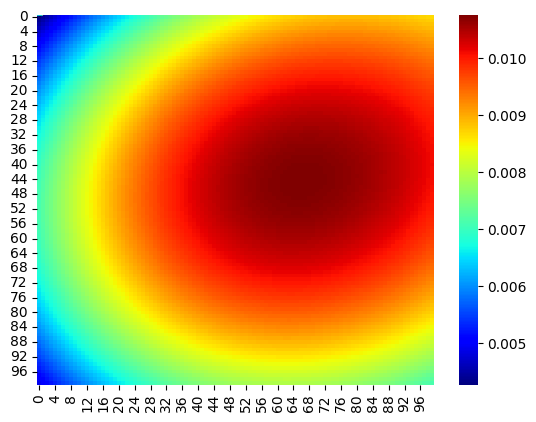

In [ ]:

with th.no_grad():

    x = th.linspace(0,1,100)
    y = th.linspace(0,1,100)

    x,y = th.meshgrid(x,y)
    t = .0 * th.ones_like(x)


    inputs = th.stack([x.flatten() ,y.flatten() , t.flatten() ],dim=1)
    u = model(inputs).reshape(x.shape ,y.shape )

    # plt.contourf(x,y,u,levels =0)
    # plt.colorbar()

    plt.plot(x,u[89,:])
    # print(u)
    sns.heatmap(u,cmap='jet')

In [ ]:
num_points = 16
# th.rand(size =(num_points,1) ,requires_grad=True)
th.tensor([0.0 , 1.0]).repeat(num_points//2), th.rand(num_points)


(tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]),
 tensor([0.7557, 0.1467, 0.1204, 0.5670, 0.8449, 0.0826, 0.1257, 0.9903, 0.6847,
         0.1054, 0.9689, 0.8862, 0.8298, 0.3157, 0.4203, 0.5096]))

In [ ]:
x_boundary = th.tensor([0.0 , 1.0]).repeat(num_points//2)
y_boundary = th.rand(num_points)

if th.rand(1) > 0.5 :
    x_boundary,y_boundary = y_boundary ,x_boundary

x_boundary,y_boundary

(tensor([0.6494, 0.4759, 0.7789, 0.1493, 0.6140, 0.1879, 0.1001, 0.8466, 0.5360,
         0.0690, 0.0520, 0.3688, 0.6589, 0.3581, 0.7468, 0.5253]),
 tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]))